# Preprocessing of the dataset

### Ho usato gli stessi valori che nel preprocessing del dataset d'esempio ma non ho capito in base a cosa si scelgono

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.5 umap==0.5.2 numpy==1.20.0 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.0 pynndescent==0.5.5


In [3]:
results_file = './write/MouseData.h5ad'
results_file_not_filtered = './write/MouseDataNotFiltered.h5ad'
results_file_pca = './write/MouseDataPca.h5ad'
results_file_umap = './write/MouseDataUmap.h5ad'
results_file_annotation = './write/MouseDataAnn.h5ad'

In [4]:
adata=sc.read_10x_mtx('./filtered_feature_bc_matrix/',
    var_names='gene_symbols',
    cache=True)

... reading from cache file cache/filtered_feature_bc_matrix-matrix.h5ad


In [5]:
adata.shape
raw_data = adata

In [6]:
adata

AnnData object with n_obs × n_vars = 4721 × 32285
    var: 'gene_ids'

## Highest Gene Expressed
Per ogni gene calcola il numero di reads mappati e prende i primi 20: normalizza per ogni cellula i counts

normalizing counts per cell
    finished (0:00:00)


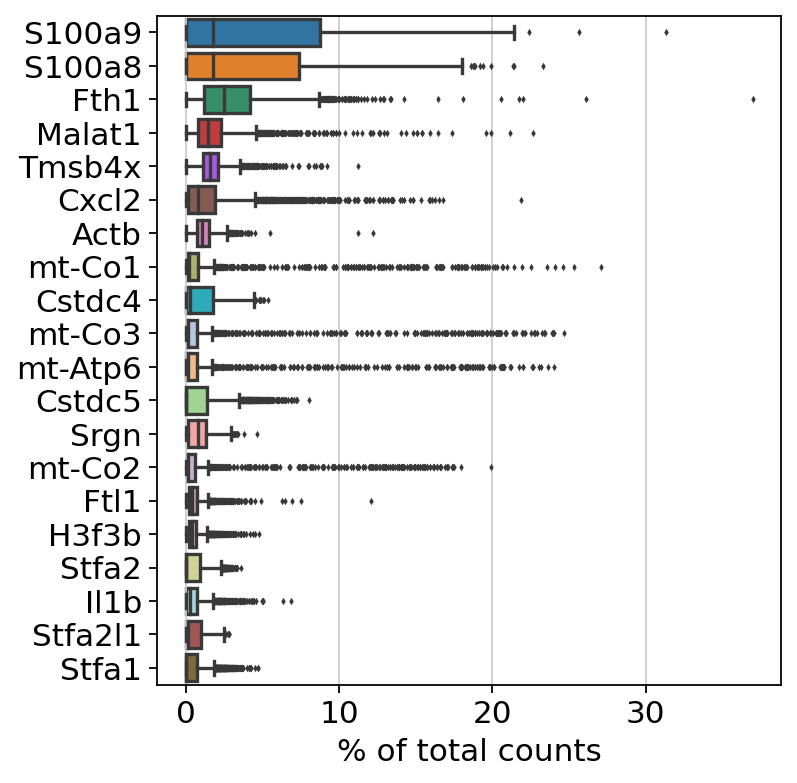

In [73]:
sc.pl.highest_expr_genes(adata, n_top=20) #i 20 geni più espressi

## Filter Cells e Filter Genes
Domanda: sono valori standard o in base al dataset scelgo cosa e quanto escludere? La seconda mi sembra più probabile.\
Quindi in questo caso si dovrebbero usare altri valori?

In [74]:
sc.pp.filter_cells(adata, min_genes=200) #filtro le cellule che hanno meno di 200 geni espressi
sc.pp.filter_genes(adata, min_cells=3) #filtro i geni espressi in meno di 3 cellule


filtered out 115 cells that have less than 200 genes expressed
filtered out 14742 genes that are detected in less than 3 cells


## Elimino i geni mitocondriali
### Per farlo devo annotare i geni che iniziano con "mt-" in questo caso
Perché? Sono geni che molto spesso sono dispersi nella cellula e caratteristici di cellule in apoptosi quindi potrebbe indurmi a fare degli errori o avere dei calcoli sbagliati

In [75]:
adata.var['mt']= adata.var_names.str.startswith('mt-') #annotazione dei gruppi di geni mitocondriali
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) #calcolo la percentuale di geni mitocondriali

### Violin Plot

... storing 'feature_types' as categorical


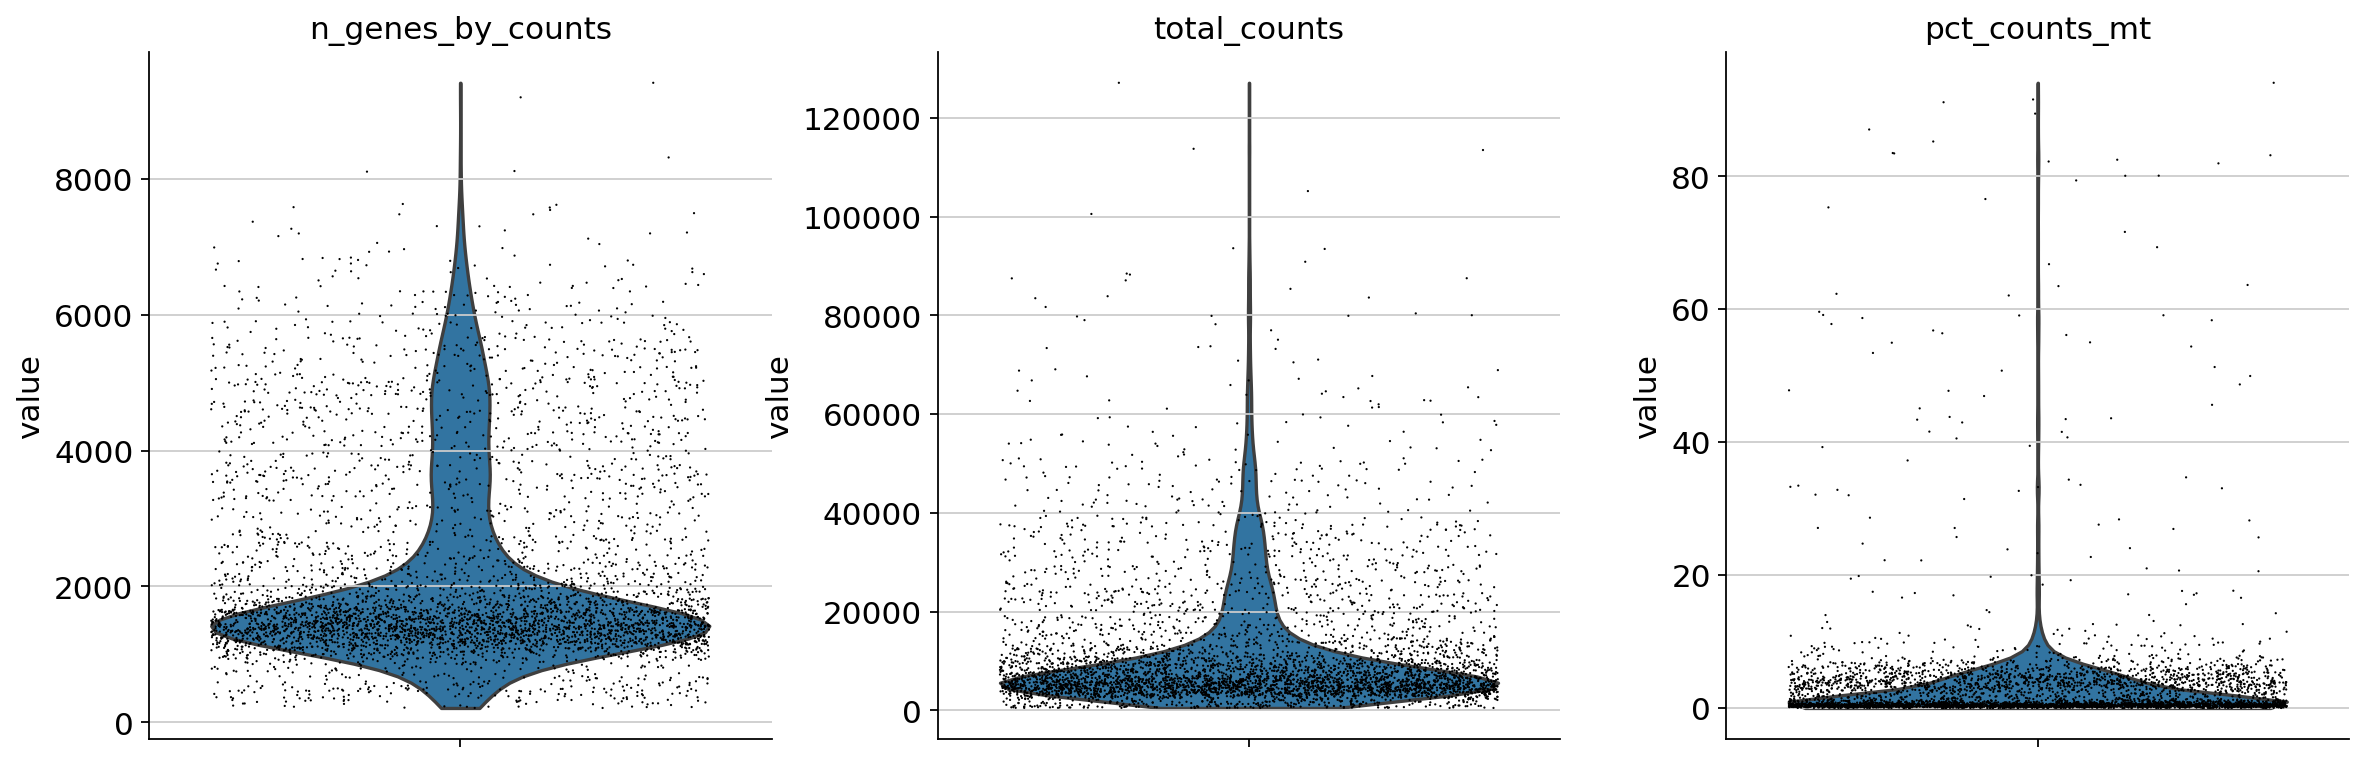

In [76]:
#violin plot del numero di geni per counts, counts totali e la percentuale di counts mitocondriali
sc.pl.violin(adata, ['n_genes_by_counts','total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True) 

### Plot delle counts mitocondriali sulle totali e del numero di geni per counts sulle totali
Non molto espressivo

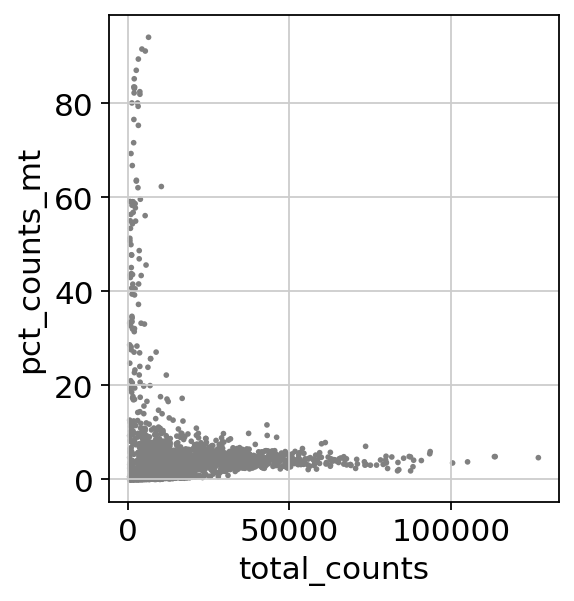

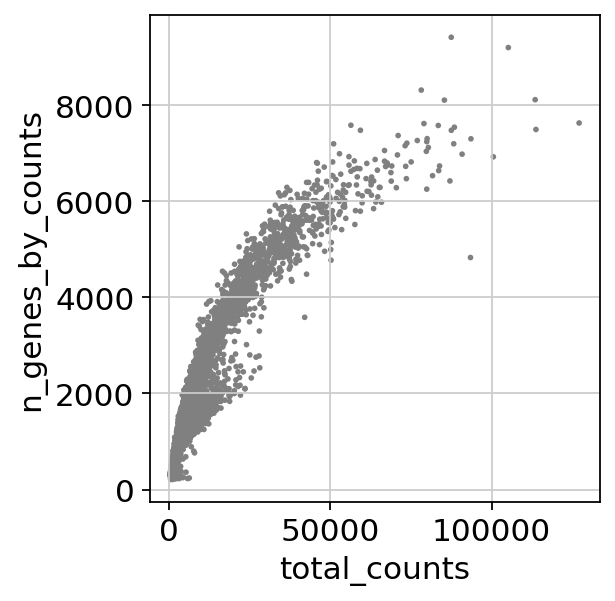

In [77]:
sc.pl.scatter(adata, x='total_counts',y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts',y='n_genes_by_counts')

### Rimuovo le cellule con più di 5 counts mitocondriali
### Rimuovo le cellule con troppe counts totali (più di 2500)
Perché?
- Le counts per i geni mitocondriali per quanto detto sopra
- Le cellule con troppe counts perché probabilmente sono frutto d'errore (ad esempio due cellule considerate come una sola)

## Provo nuovi dati dal violin plot

In [78]:
#adata = adata[adata.obs.n_genes_by_counts < 8000, :]
#adata = adata[adata.obs.pct_counts_mt < 15, :]
#adata

In [79]:
#violin plot del numero di geni per counts, counts totali e la percentuale di counts mitocondriali
#sc.pl.violin(adata, ['n_genes_by_counts','total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True) 

In [80]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 12, :]
adata

/home/chiara/anaconda3/envs/scan/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 4362 × 17543
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

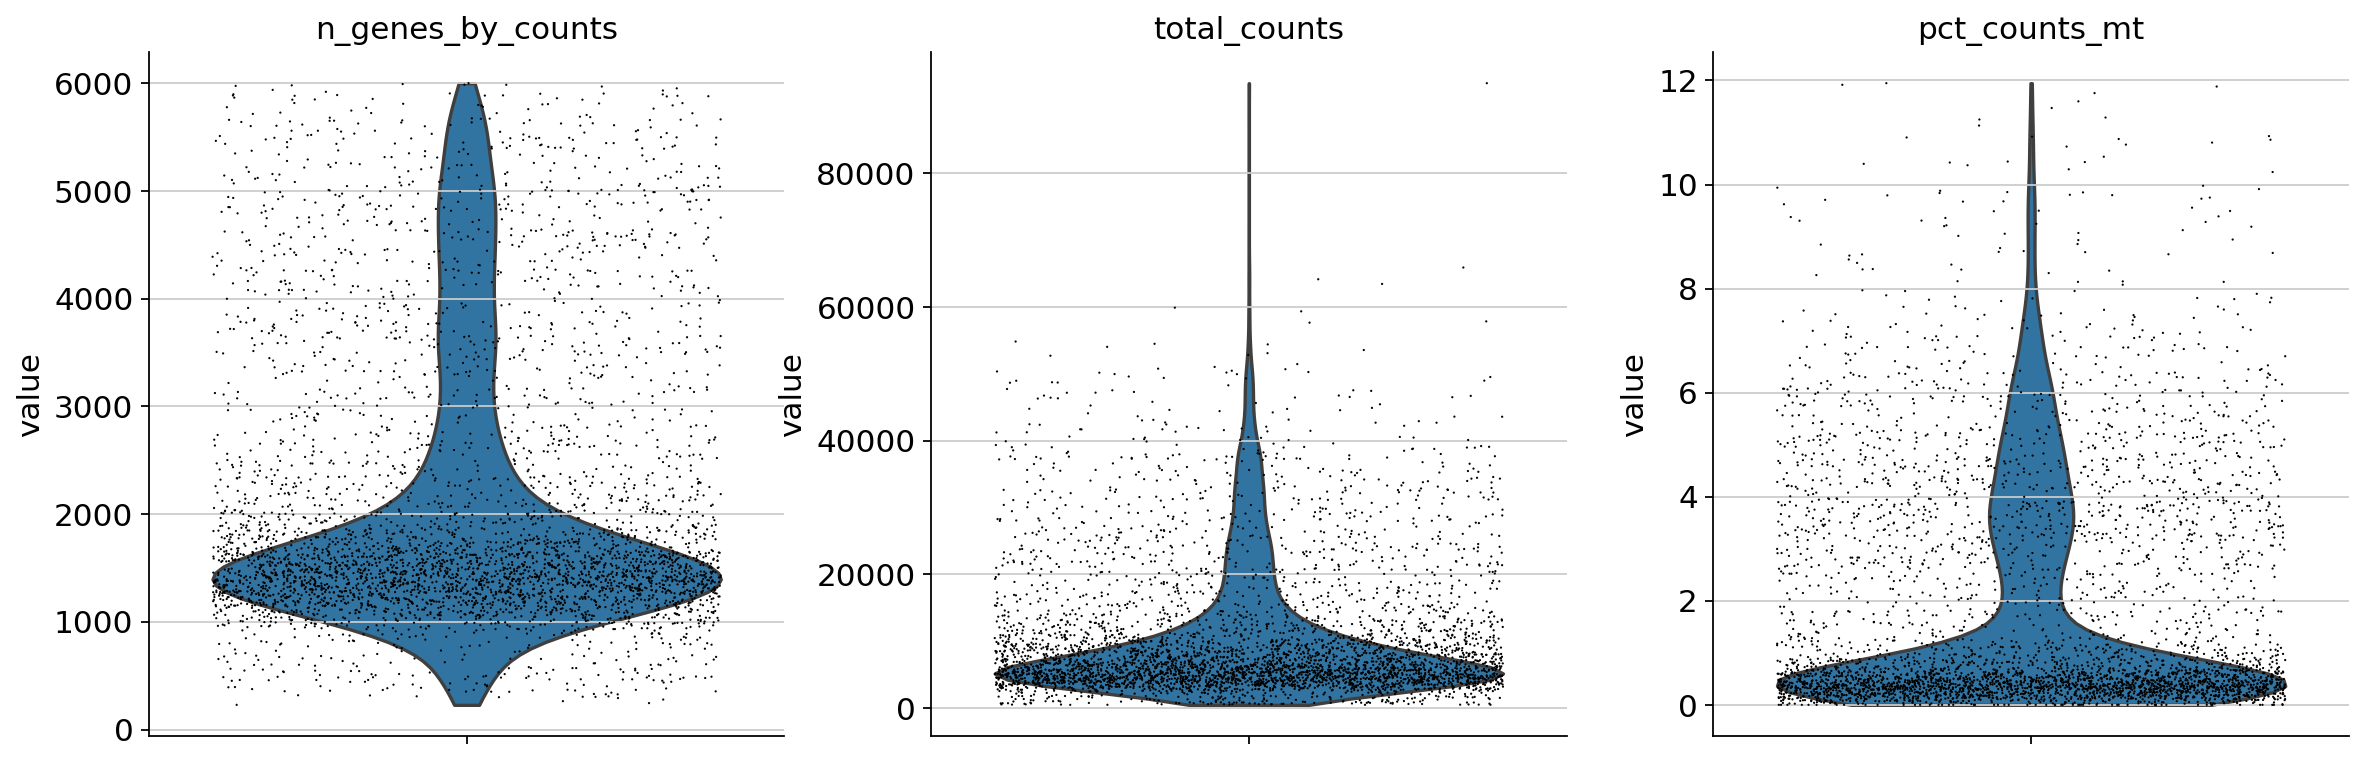

In [81]:
#violin plot del numero di geni per counts, counts totali e la percentuale di counts mitocondriali
sc.pl.violin(adata, ['n_genes_by_counts','total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True) 

## Rimuovo le cellule con i valori dati dal dataset di prova 

In [82]:
#adata = adata[adata.obs.n_genes_by_counts < 2500, :]
#adata = adata[adata.obs.pct_counts_mt < 5, :]
#adata

In [83]:
#violin plot del numero di geni per counts, counts totali e la percentuale di counts mitocondriali
#sc.pl.violin(adata, ['n_genes_by_counts','total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True) 

### Normalizzazione delle counts totali
CPM = (number of reads x 10^6)/total number

In [84]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/chiara/anaconda3/envs/scan/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Logaritmizzazione
Faccio in modo che la distribuzione sia simil normale perché la maggior parte dei tools assume che sia così ma non è quasi mai vero

In [85]:
sc.pp.log1p(adata)

In [86]:
adata.raw = adata

### Identificare i geni altamente variabili
Viene fatto perché voglio rimuovere tutto il rumore possibile\
#### Come funziona?
- 1° modalità: La dispersione normalizzata è ottenuta scalando con la media e la deviazione standard delle dispersioni per i geni che ricadono in un dato bin per l'espressione media dei geni. Ciò significa che per ogni bin di espressione media vengono selezionati geni altamente variabili.
- 2° modalità: viene calcolata una varianza normalizzata per ciascun gene. Innanzitutto, i dati vengono standardizzati (ovvero, normalizzazione del punteggio z per caratteristica) con una deviazione standard regolarizzata. Successivamente, la varianza normalizzata viene calcolata come la varianza di ciascun gene dopo la trasformazione. I geni sono classificati in base alla varianza normalizzata.

### L'uso dell'uno o dell'altro metodo dipende dal parametro flavor:
Depending on flavor, this reproduces the R-implementations of Seurat [Satija15], Cell Ranger [Zheng17], and Seurat v3 [Stuart19].\
Di default il flavor è settato su 'seurat'

In [87]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


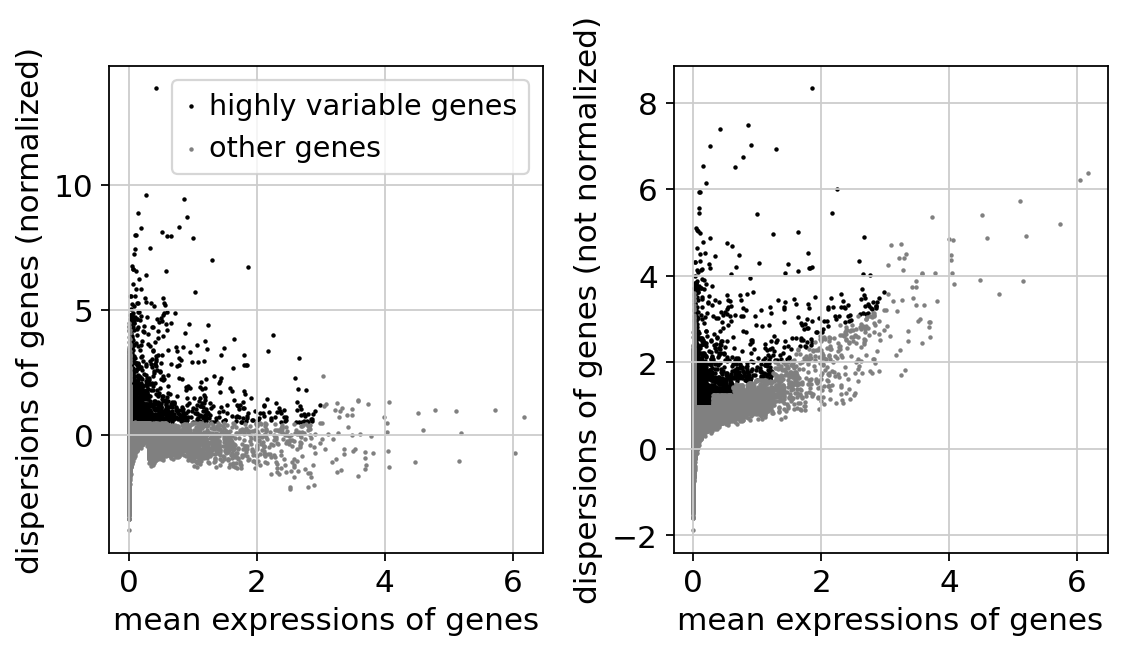

In [88]:
sc.pl.highly_variable_genes(adata)

### Provo il secondo metodo con flavor 'cell_ranger'
cell ranger passa come parametro gli n_top_genes mentre seurat passa i limiti (cutoffs)

In [89]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, flavor='cell_ranger') 

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


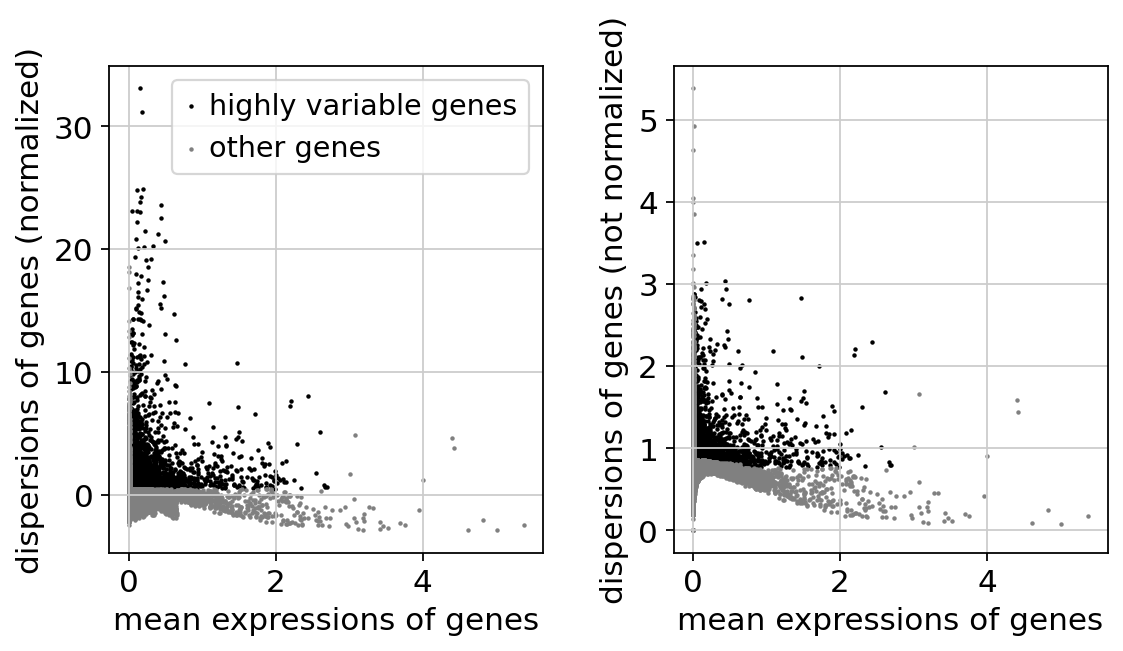

In [90]:
sc.pl.highly_variable_genes(adata)

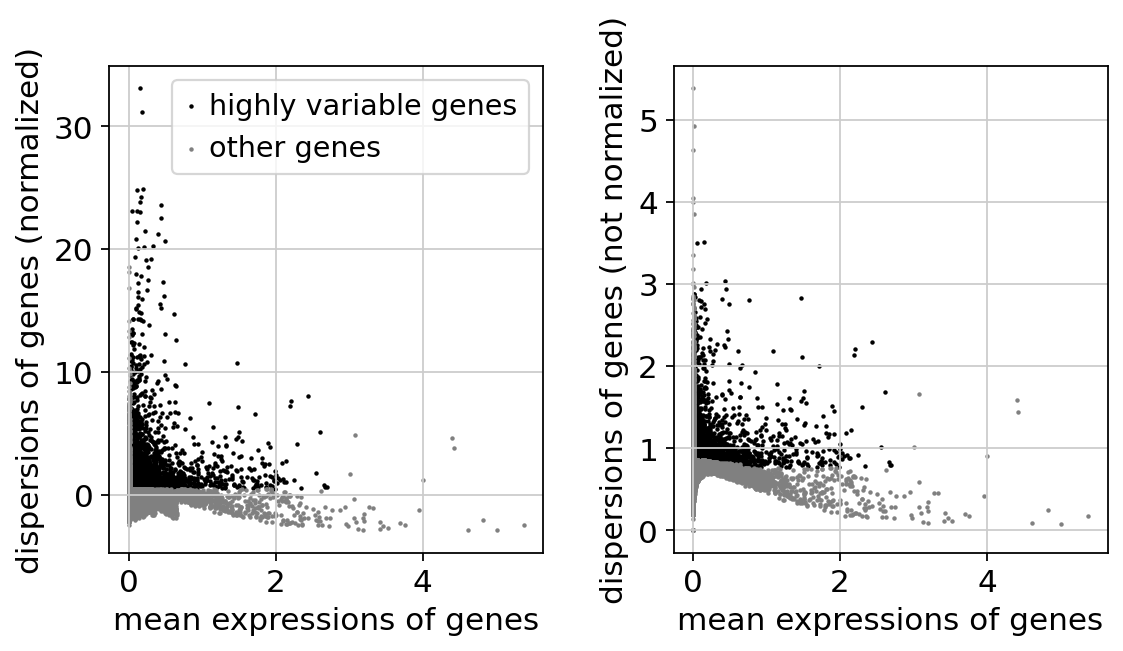

In [91]:
sc.pl.highly_variable_genes(adata)

### Interesse: analisi dei geni non altamente variabili che vengono filtrati nell'analisi

In [92]:
not_adata = adata[:, adata.var.highly_variable == False]

/home/chiara/anaconda3/envs/scan/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [93]:
not_adata.write(results_file_not_filtered)

### Inserisco i dati preprocessati come raw data così da averli sempre disponibili

In [94]:
adata.raw=adata

In [95]:
adata = adata[:, adata.var.highly_variable]

### Regressione e Scaling

In [96]:
sc.pp.regress_out(adata,  ['total_counts','pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:49)


In [97]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


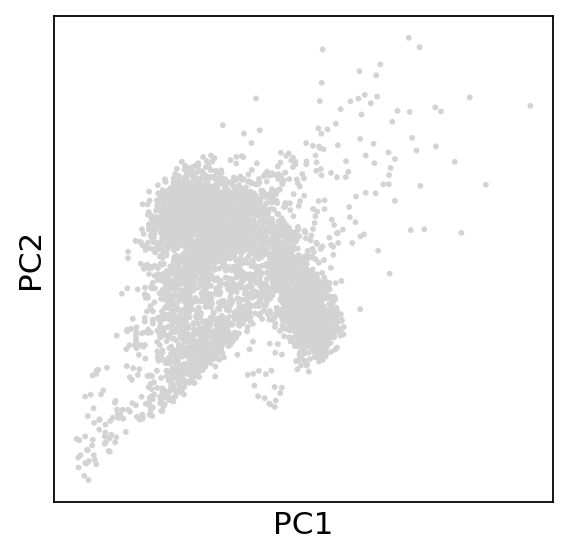

In [98]:
sc.pl.pca(adata)

In [99]:
adata.write(results_file_pca)

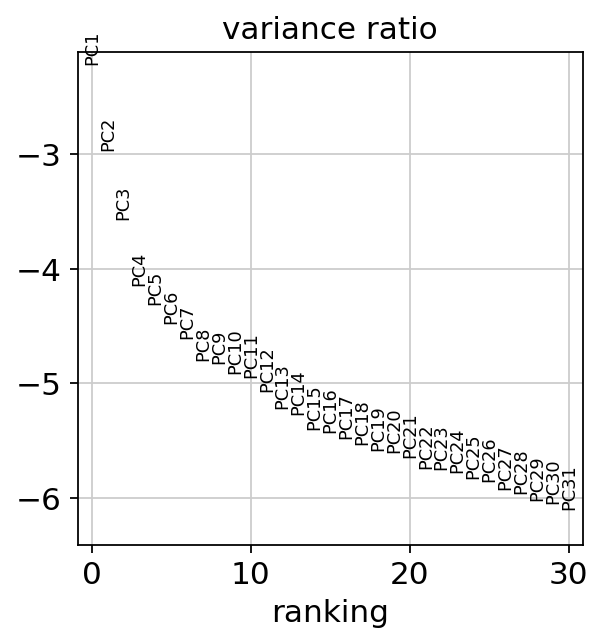

In [100]:
sc.pl.pca_variance_ratio(adata, log=True)

Le pc più significative sono le prime 10/12.<br> La prima e la seconda hanno un grandissimo distacco dalle altre

In [101]:
adata.write(results_file) 

In [102]:
adata

AnnData object with n_obs × n_vars = 4362 × 3311
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# Computazione del neighborhood graph

In [103]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) #40 sono forse troppe

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [104]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15) #provo con 15

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


# Embedding del neighborhood graph

In [105]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


In [106]:
adata.write(results_file_umap)

# Effettuo sia leiden che louvain sul dataset
In due computazioni differenti

In [107]:
#sc.tl.louvain(adata)

In [108]:
#sc.pl.umap(adata, color=['louvain'])

In [109]:
#sc.tl.louvain(adata, resolution=0.5)

In [110]:
#sc.pl.umap(adata, color=['louvain'])

In [111]:
#sc.tl.louvain(adata, resolution=1.5)

In [112]:
#sc.pl.umap(adata, color=['louvain'])

In [113]:
#sc.tl.leiden(adata)

In [114]:
#sc.pl.umap(adata, color=['leiden'])

In [115]:
sc.tl.leiden(adata, resolution=0.5)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [116]:
#
# sc.tl.leiden(adata, resolution=0.2)

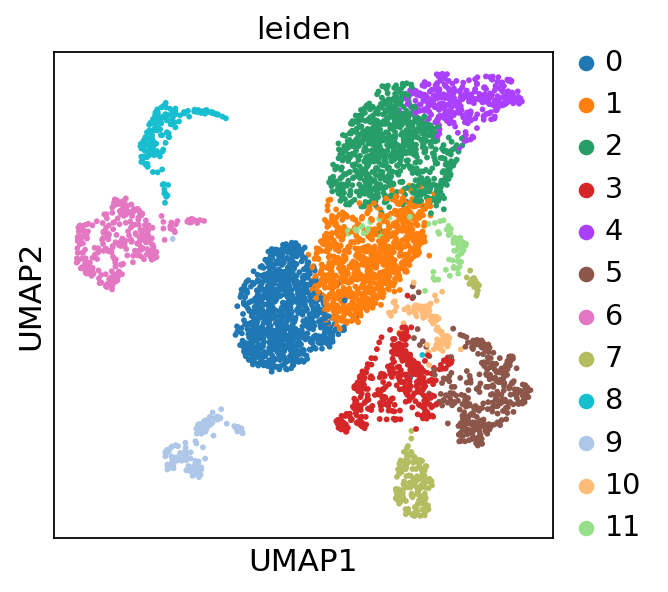

In [117]:
sc.pl.umap(adata, color=['leiden'])

In [118]:
#sc.tl.leiden(adata, resolution=2)

In [119]:
#sc.pl.umap(adata, color=['leiden'])

# Perché PAGA?
PAGA quantifica la connettività delle partizioni (cluster) del grafico single cell, generando un grafico astratto molto più semplice (grafico PAGA) delle partizioni, in cui i pesi degli archi rappresentano la "fiducia" dell'effettiva presenza di connessioni . 
Veniva infatti suggerito nell'analisi tipo nel caso di grafi che risultassero poi in cluster disonnessi

In [120]:
#sc.tl.paga(adata)

In [121]:
#sc.pl.paga(adata, plot=False)
#sc.tl.umap(adata, init_pos='paga')

In [122]:
#sc.pl.umap(adata,color=['leiden'])

In [123]:
adata.write(results_file_annotation)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


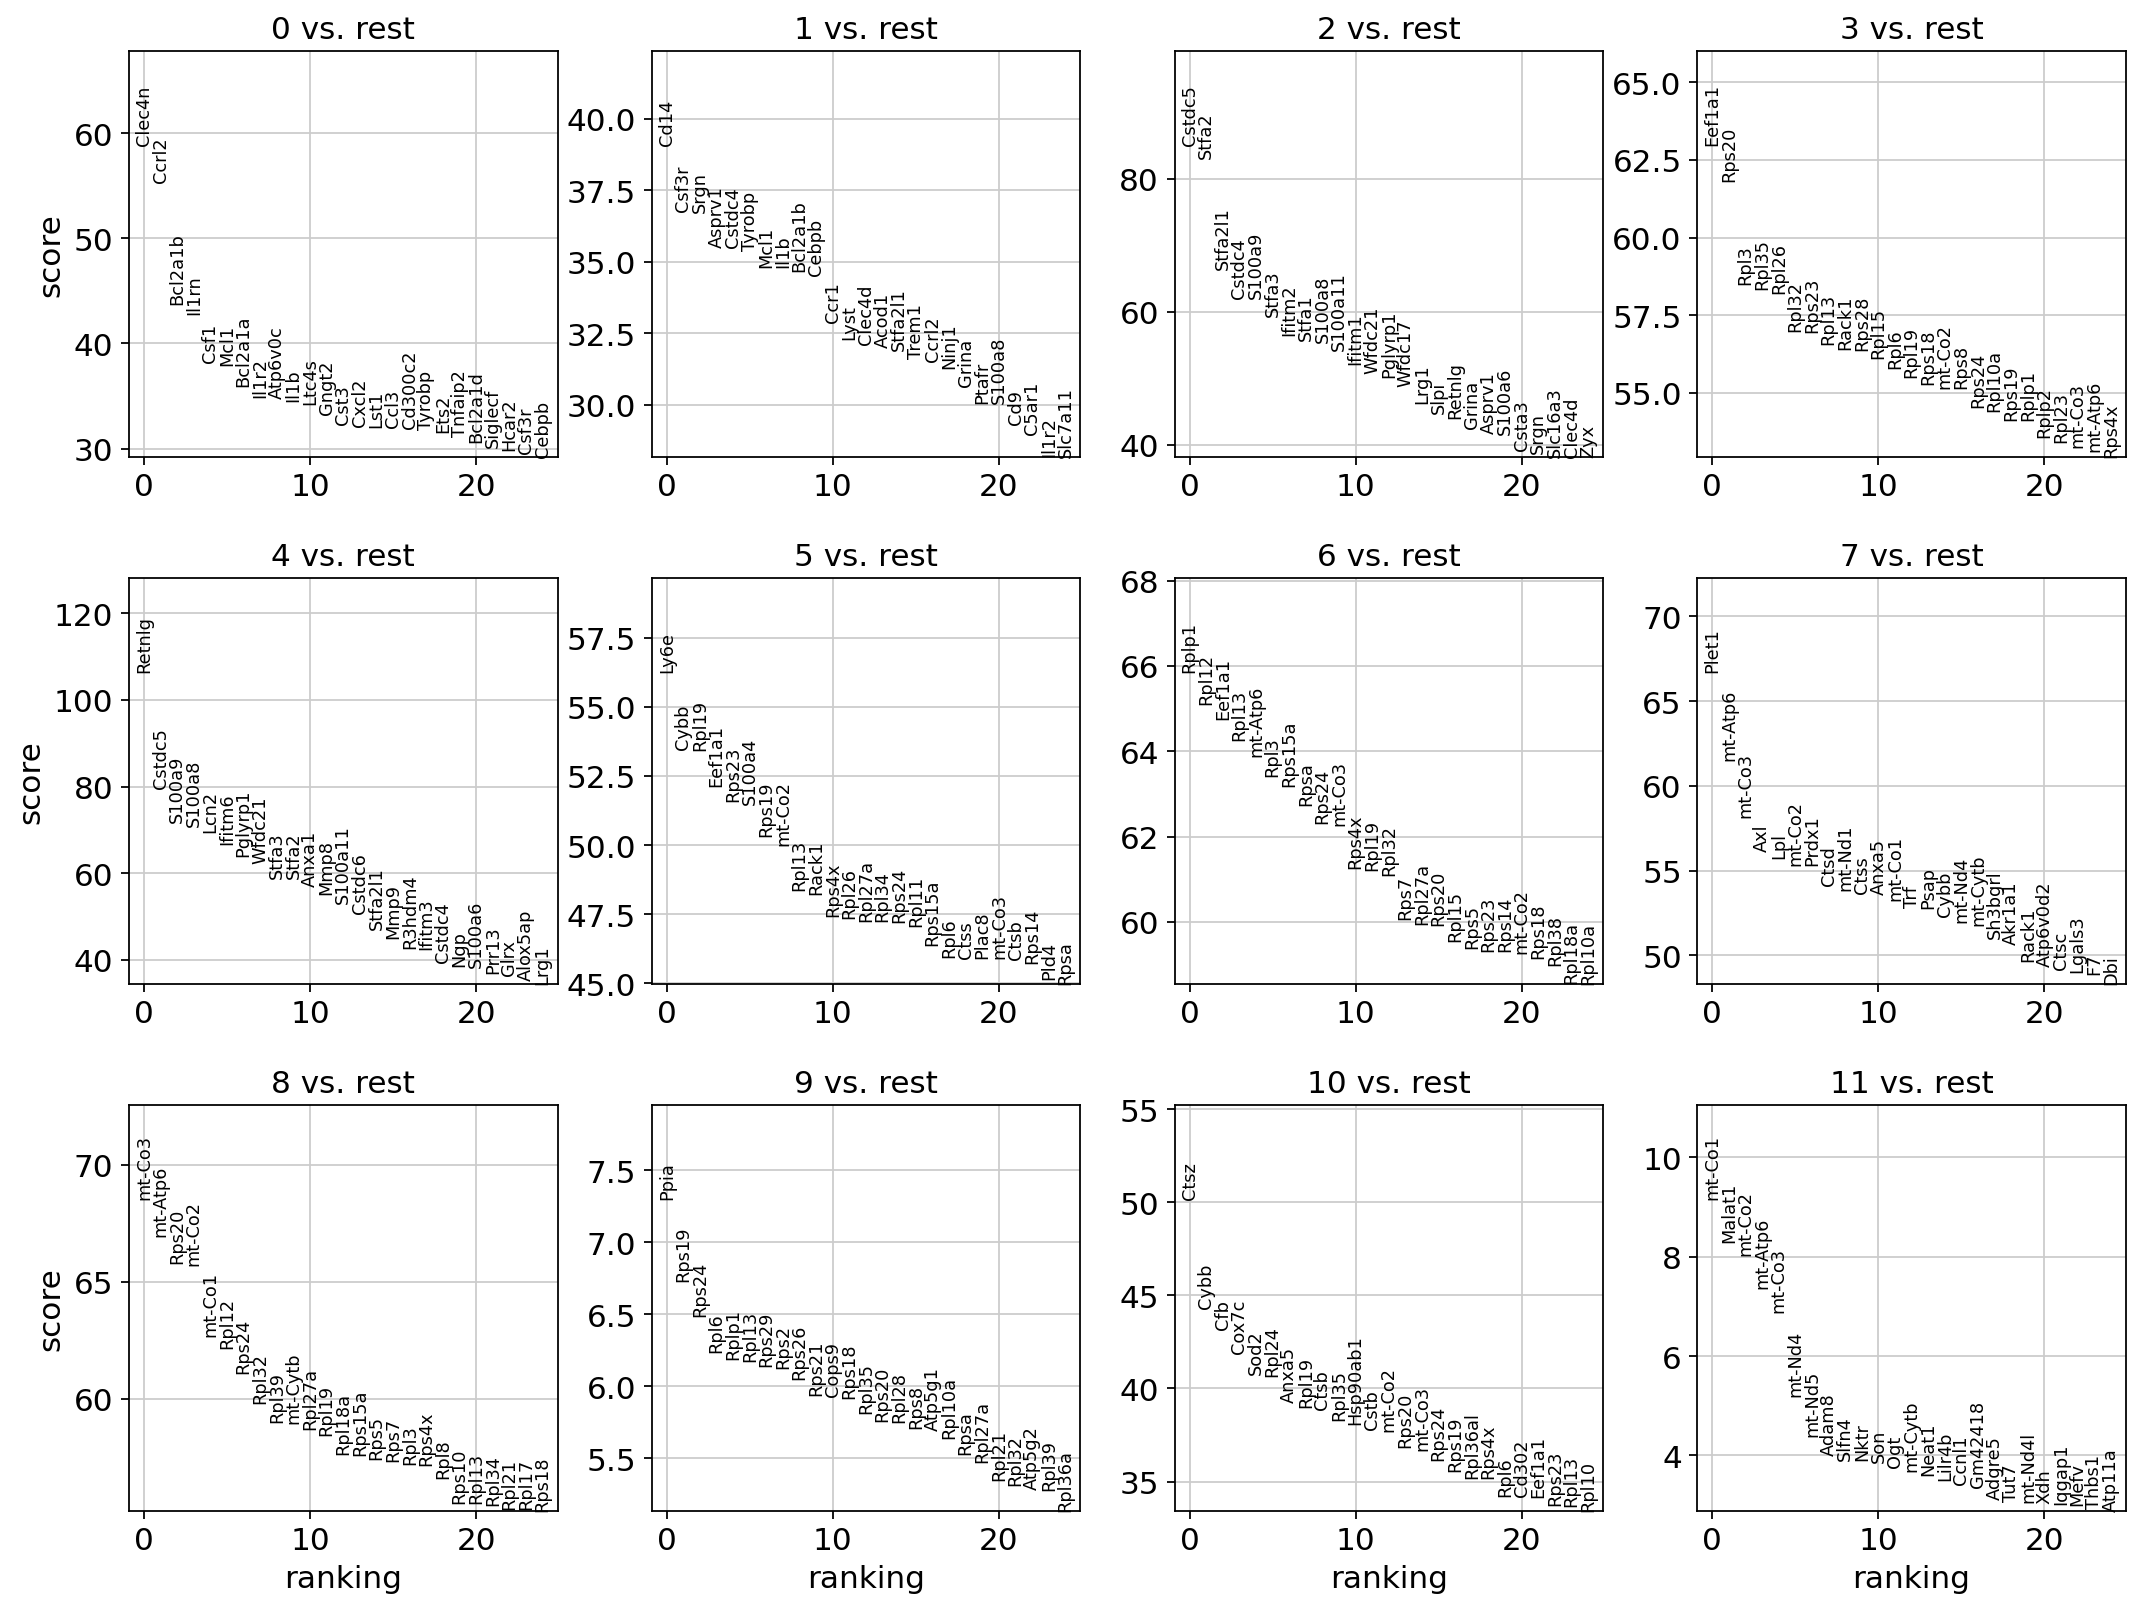

In [124]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [125]:
sc.settings.verbosity=2

In [126]:
#sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [127]:
#sc.tl.rank_genes_groups(adata, 'leiden', method='logreg', solver='liblinear')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [128]:
marker_genes = ['Clec4n','Cd14','Cstdc5','Eef1a1','Retnlg','Ly6e','Rplp1','Plet1','mt-Co3','Ppia','Ctsz','mt-Co1',
'Ccrl2','Srgn','Stfa2','Rps20','Cstdc5','Cybb','Rpl12','mt-Atp6','mt-Atp6','Rps19','Sod2','Malat1',
'Bcl2a1b','Csf3r','Stfa2l1','Rpl3','S100a9','Rpl19','Eef1a1','mt-Co3','Rps20','Rps24','Cfb','mt-Co2']

In [129]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

0        1        2       3        4       5        6        7  \
0    Clec4n     Cd14   Cstdc5  Eef1a1   Retnlg    Ly6e    Rplp1    Plet1   
1     Ccrl2    Csf3r    Stfa2   Rps20   Cstdc5    Cybb    Rpl12  mt-Atp6   
2   Bcl2a1b     Srgn  Stfa2l1    Rpl3   S100a9   Rpl19   Eef1a1   mt-Co3   
3     Il1rn   Asprv1   Cstdc4   Rpl35   S100a8  Eef1a1    Rpl13      Axl   
4      Csf1   Cstdc4   S100a9   Rpl26     Lcn2   Rps23  mt-Atp6      Lpl   
5      Mcl1   Tyrobp    Stfa3   Rpl32   Ifitm6  S100a4     Rpl3   mt-Co2   
6   Bcl2a1a     Mcl1   Ifitm2   Rps23  Pglyrp1   Rps19   Rps15a    Prdx1   
7     Il1r2     Il1b    Stfa1   Rpl13   Wfdc21  mt-Co2     Rpsa     Ctsd   
8   Atp6v0c  Bcl2a1b   S100a8   Rack1    Stfa3   Rpl13    Rps24   mt-Nd1   
9      Il1b    Cebpb  S100a11   Rps28    Stfa2   Rack1   mt-Co3     Ctss   
10    Ltc4s     Ccr1   Ifitm1   Rpl15    Anxa1   Rps4x    Rps4x    Anxa5   
11    Gngt2     Lyst   Wfdc21    Rpl6     Mmp8   Rpl26    Rpl19   mt-Co1   
12     Cst3   Clec4d  Pglyrp1   Rpl19  S100a11  Rpl27a    Rpl32      Trf   
13    Cxcl2    Acod1   Wfdc17   Rps18   Cstdc6   Rpl34     Rps7     Psap   
14     Lst1  Stfa2l1     Lrg1  mt-Co2  Stfa2l1   Rps24   Rpl27a     Cybb   
15     Ccl3    Trem1     Slpi    Rps8     Mmp9   Rpl11    Rps20   mt-Nd4   
16  Cd300c2    Ccrl2   Retnlg   Rps24   R3hdm4  Rps15a    Rpl15  mt-Cytb   
17   Tyrobp    Ninj1    Grina  Rpl10a   Ifitm3    Rpl6     Rps5  Sh3bgrl   
18     Ets2    Grina   Asprv1   Rps19   Cstdc4    Ctss    Rps23   Akr1a1   
19  Tnfaip2    Ptafr   S100a6   Rplp1      Ngp   Plac8    Rps14    Rack1   

          8       9        10       11  
0    mt-Co3    Ppia      Ctsz   mt-Co1  
1   mt-Atp6   Rps19      Cybb   Malat1  
2     Rps20   Rps24       Cfb   mt-Co2  
3    mt-Co2    Rpl6     Cox7c  mt-Atp6  
4    mt-Co1   Rplp1      Sod2   mt-Co3  
5     Rpl12   Rpl13     Rpl24   mt-Nd4  
6     Rps24   Rps29     Anxa5   mt-Nd5  
7     Rpl32    Rps2     Rpl19    Adam8  
8     Rpl39   Rps26      Ctsb    Slfn4  
9   mt-Cytb   Rps21     Rpl35     Nktr  
10   Rpl27a   Cops9  Hsp90ab1      Son  
11    Rpl19   Rps18      Cstb      Ogt  
12   Rpl18a   Rpl35    mt-Co2  mt-Cytb  
13   Rps15a   Rps20     Rps20    Neat1  
14     Rps5   Rpl28    mt-Co3   Lilr4b  
15     Rps7    Rps8     Rps24    Ccnl1  
16     Rpl3  Atp5g1     Rps19  Gm42418  
17    Rps4x  Rpl10a   Rpl36al   Adgre5  
18     Rpl8    Rpsa     Rps4x     Tut7  
19    Rps10  Rpl27a      Rpl6  mt-Nd4l

In [130]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'scores']}).head(10)

0_n        0_s      1_n        1_s      2_n        2_s     3_n  \
0   Clec4n  58.897842     Cd14  39.093571   Cstdc5  85.070145  Eef1a1   
1    Ccrl2  55.411213    Csf3r  36.778126    Stfa2  83.156090   Rps20   
2  Bcl2a1b  43.785793     Srgn  36.739479  Stfa2l1  66.367554    Rpl3   
3    Il1rn  42.757797   Asprv1  35.530521   Cstdc4  62.046799   Rpl35   
4     Csf1  38.225399   Cstdc4  35.528088   S100a9  62.026257   Rpl26   
5     Mcl1  37.903114   Tyrobp  35.411415    Stfa3  59.388798   Rpl32   
6  Bcl2a1a  35.911121     Mcl1  34.818916   Ifitm2  56.495758   Rps23   
7    Il1r2  34.861565     Il1b  34.812325    Stfa1  55.794056   Rpl13   
8  Atp6v0c  34.827354  Bcl2a1b  34.686039   S100a8  55.407490   Rack1   
9     Il1b  34.549183    Cebpb  34.537807  S100a11  54.226002   Rps28   

         3_s      4_n         4_s  ...      7_n        7_s      8_n  \
0  62.985500   Retnlg  106.476982  ...    Plet1  66.722206   mt-Co3   
1  61.820492   Cstdc5   79.564804  ...  mt-Atp6  61.519566  mt-Atp6   
2  58.506134   S100a9   71.877541  ...   mt-Co3  58.139862    Rps20   
3  58.334126   S100a8   70.903175  ...      Axl  56.140503   mt-Co2   
4  58.221344     Lcn2   69.438698  ...      Lpl  55.725574   mt-Co1   
5  56.997066   Ifitm6   66.799210  ...   mt-Co2  55.326946    Rpl12   
6  56.972095  Pglyrp1   63.881355  ...    Prdx1  55.306664    Rps24   
7  56.587990   Wfdc21   62.380833  ...     Ctsd  54.155899    Rpl32   
8  56.413490    Stfa3   58.861866  ...   mt-Nd1  53.852016    Rpl39   
9  56.393230    Stfa2   58.807808  ...     Ctss  53.677189  mt-Cytb   

         8_s    9_n       9_s   10_n       10_s     11_n      11_s  
0  68.543564   Ppia  7.303604   Ctsz  50.193966   mt-Co1  9.166620  
1  66.943008  Rps19  6.735485   Cybb  44.306053   Malat1  8.285852  
2  65.799538  Rps24  6.492488    Cfb  43.176838   mt-Co2  8.032364  
3  65.694099   Rpl6  6.241158  Cox7c  41.882996  mt-Atp6  7.364690  
4  62.678204  Rplp1  6.188399   Sod2  40.753456   mt-Co3  6.895005  
5  62.167164  Rpl13  6.176277  Rpl24  40.679150   mt-Nd4  5.193313  
6  61.114285  Rps29  6.140487  Anxa5  39.258598   mt-Nd5  4.382919  
7  59.817238   Rps2  6.129514  Rpl19  39.002411    Adam8  4.010553  
8  59.002068  Rps26  6.048823   Ctsb  38.874138    Slfn4  3.913279  
9  58.984104  Rps21  5.938082  Rpl35  38.297935     Nktr  3.903486  

[10 rows x 24 columns]

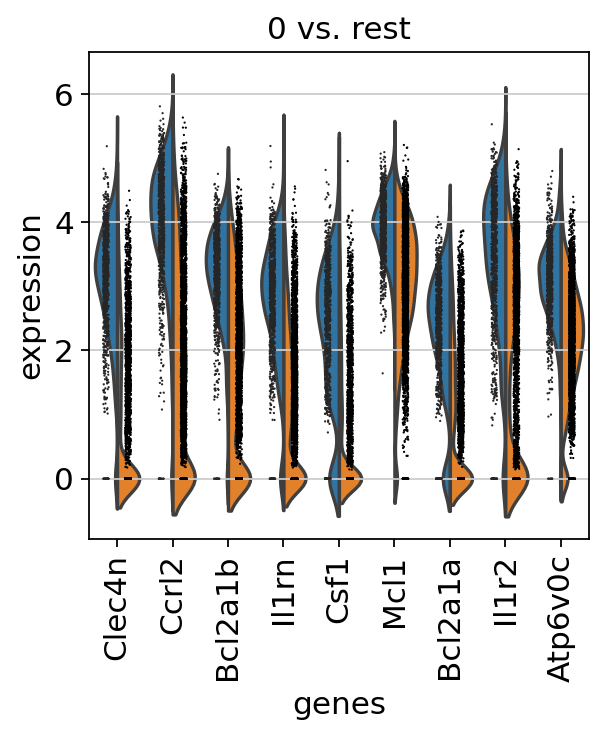

In [131]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=9)

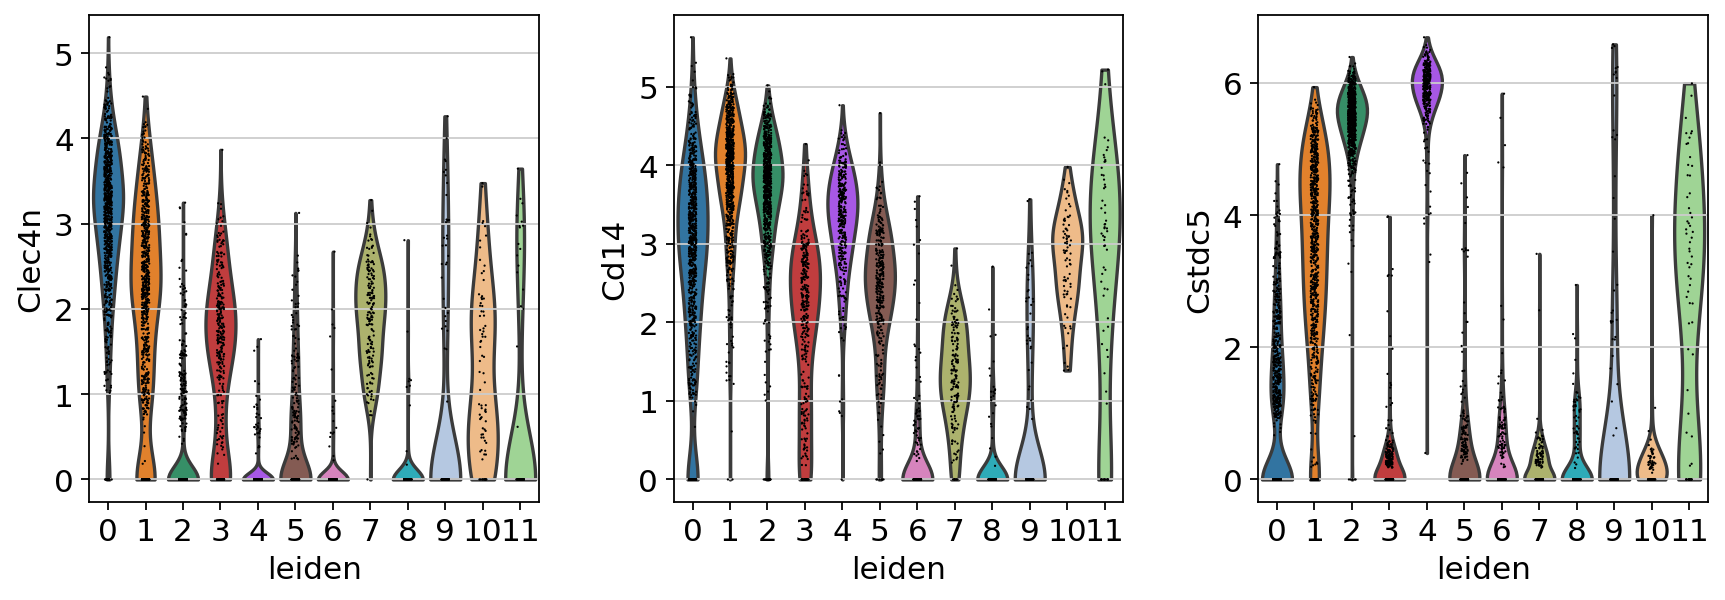

In [132]:
sc.pl.violin(adata, ['Clec4n', 'Cd14', 'Cstdc5'], groupby='leiden')

In [133]:
new_cluster_names = [
    'Microglia', 'Myeloid', 'Neutrophils', 'tre','quattro', 'Monocytes','T cells', 'Macrophages','B cells','nove','Monocytes?','Mitochondria']
adata.rename_categories('leiden', new_cluster_names)

/home/chiara/anaconda3/envs/scan/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


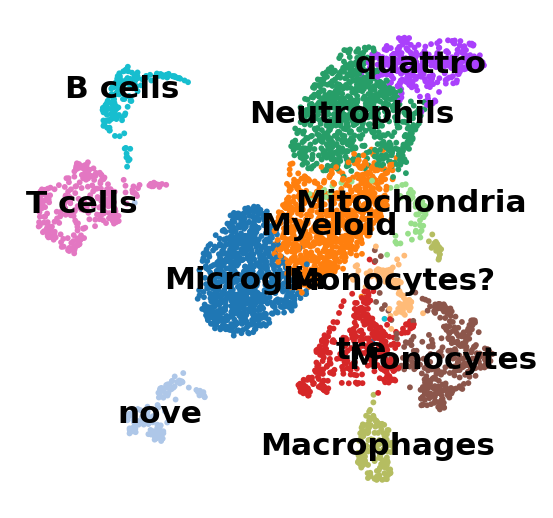

In [134]:
sc.pl.umap(adata,color='leiden',legend_loc='on data', title='', frameon=False, save='.pdf')

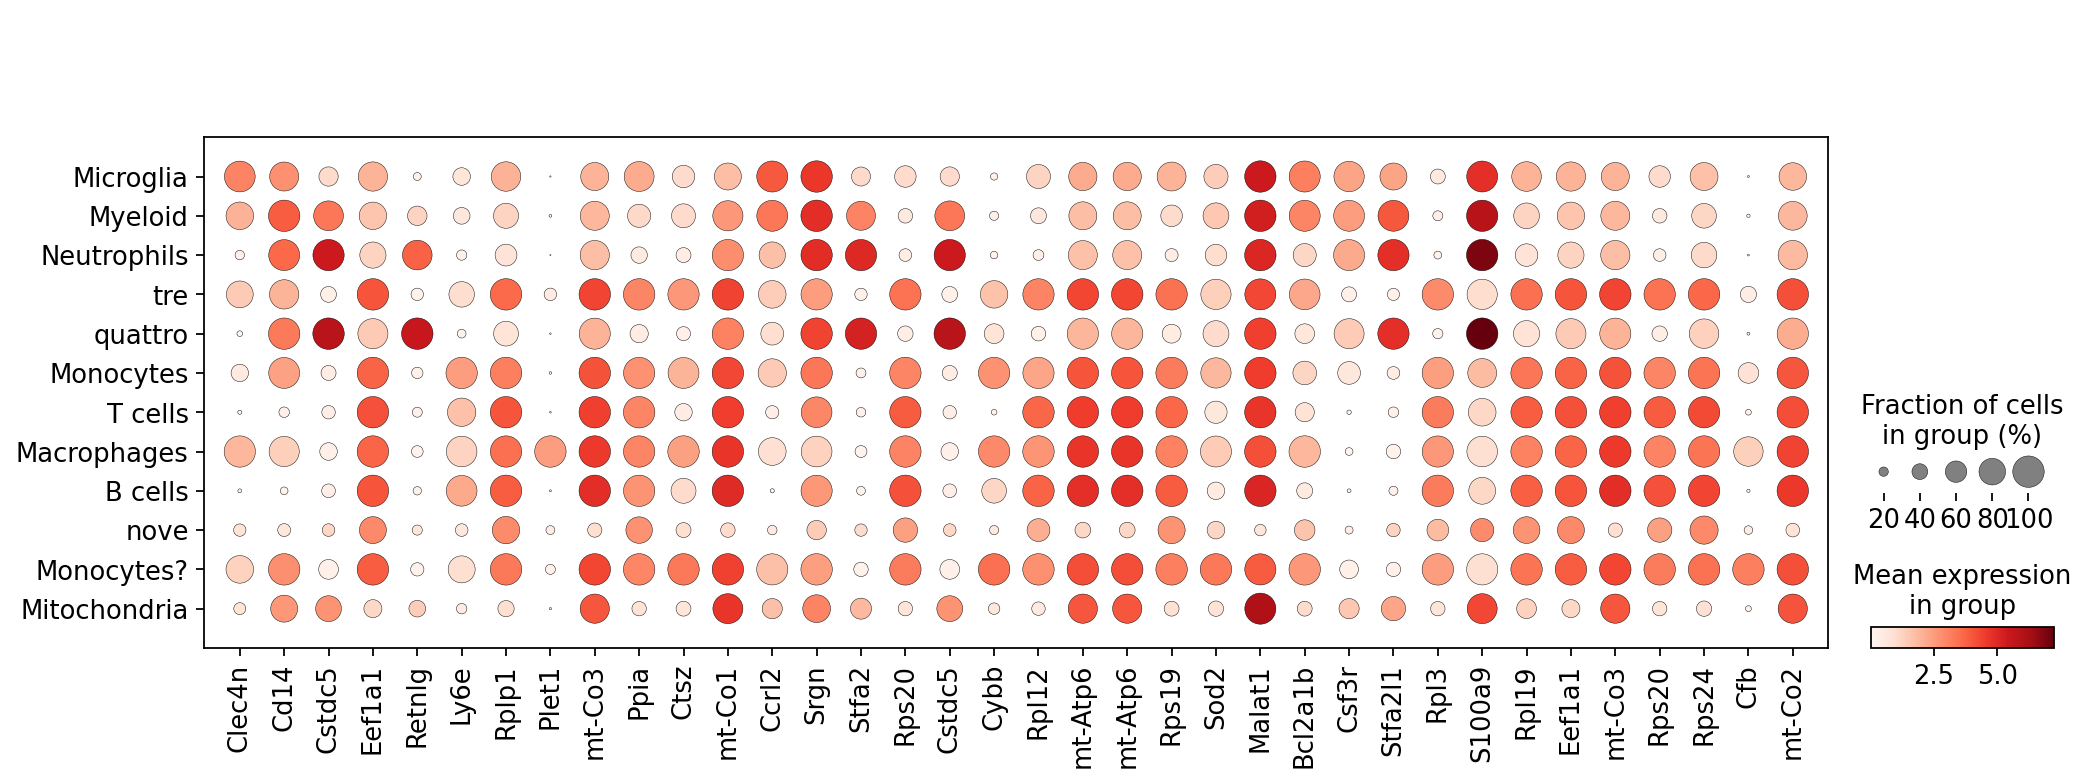

In [135]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

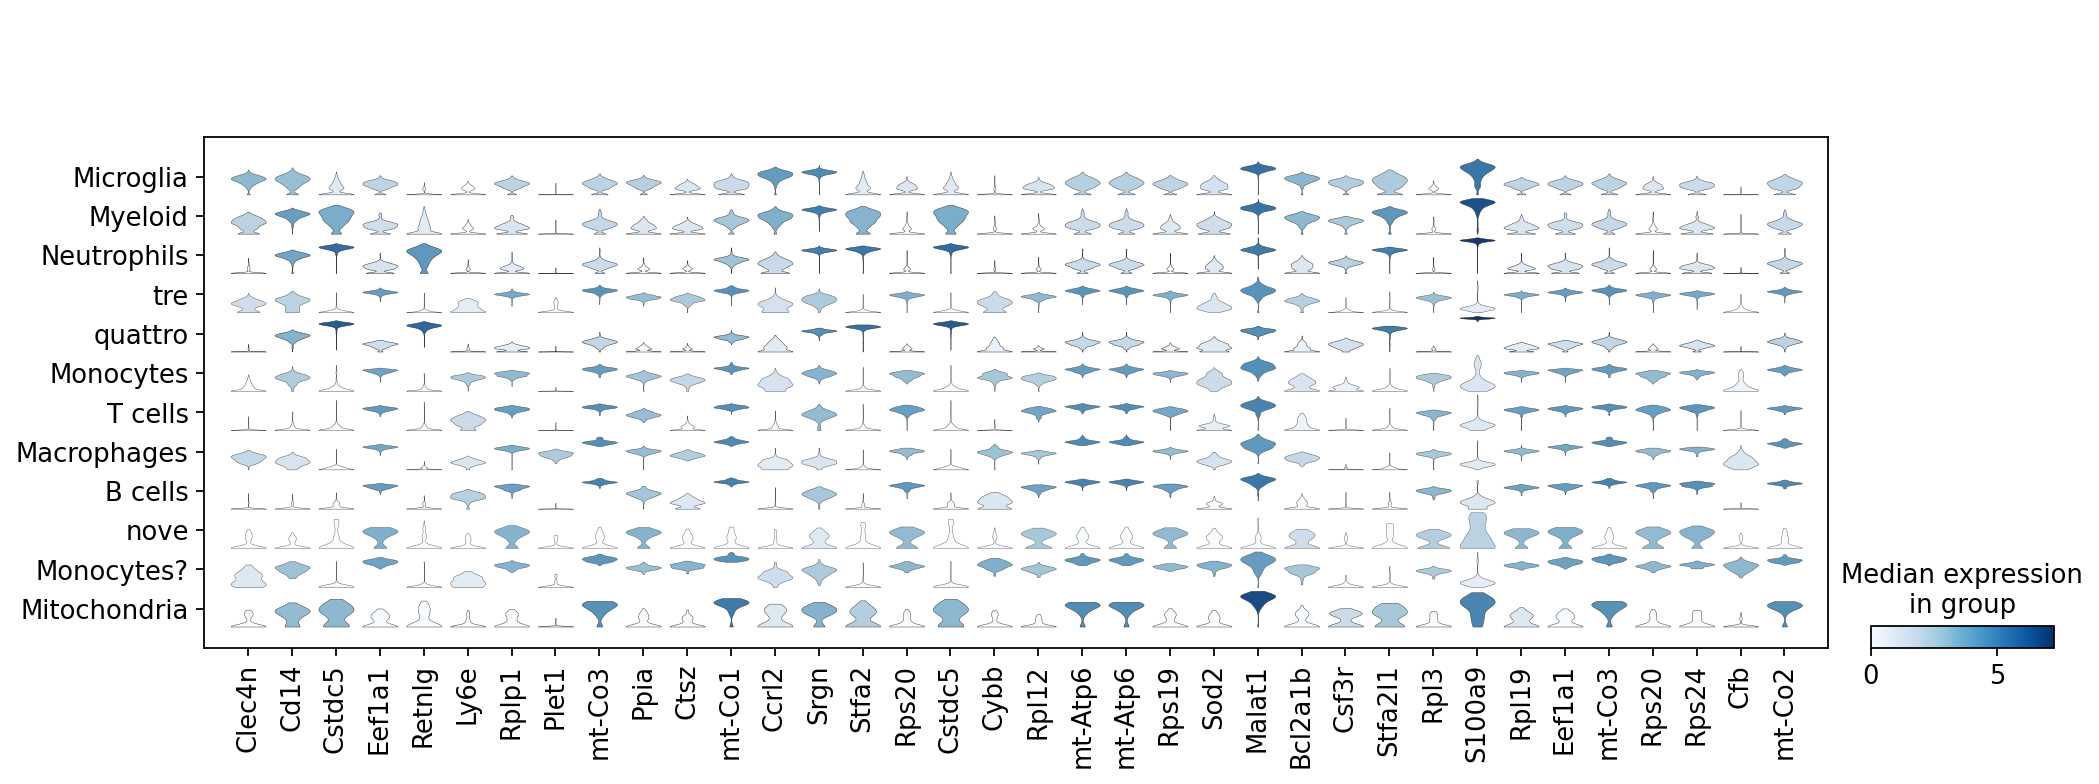

In [136]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden',rotation=90)